# Predicting Corporate Financial Distress

## 0. Introduction

Corporate bankruptcy is rarely a one-day event. Firms usually show clear
financial distress signals several years before they actually fail.
In this project, we use a panel dataset of U.S. firms to study how
financial variables evolve in the years leading up to bankruptcy and
to build models that can predict whether a firm will fail in the near future.

Our main research questions are:

- RQ1: Do bankrupt firms look different from healthy firms in the three years
  before failure?
- RQ2: Which financial ratios deteriorate earliest and could serve as early-warning
  indicators?
- RQ3: Can we use these variables to train predictive models (Logistic Regression,
  XGBoost, Neural Network) that flag risky firms ahead of time?
- RQ4: How do differences in model performance and variable importance across Logistic Regression, XGBoost, and Neural Networks inform our understanding of the bankruptcy process?

---

## 1. Setup and Install Dependencies


In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, f1_score
)

from xgboost import XGBClassifier


---

## 2. Data Loading and Initial Cleaning

In this section we load the **American Bankruptcy** dataset into a pandas
DataFrame. Each row corresponds to a firm–year observation identified by
`company_name` and `year`, and the column `status_label` indicates whether
the firm is *alive*, *failed* or *bankrupt*.

The raw file uses generic column names `X1`–`X18`. We immediately rename
these into interpretable financial statement items (e.g. `current_assets`,
`net_income`, `total_assets`, `retained_earnings`) using a dictionary,
so that all subsequent tables and plots are easier to interpret.


### 2.1 Basic data checks

We perform simple checks for missing values and inspect the distribution
of the target variable `status_label`. The bar chart below shows that
failed/bankrupt observations are much rarer than alive ones, which
indicates that the classification problem is imbalanced.


In [ ]:
df = pd.read_csv('/content/american_bankruptcy.csv')
df

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,...,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,...,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,...,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,...,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713


In [ ]:
# convert the raw data categories(X1,X2,...,X18) into real label
rename_dict = {
    "X1": "current_assets",
    "X2": "cost_of_goods_sold",
    "X3": "depreciation_amortization",
    "X4": "ebitda",
    "X5": "inventory",
    "X6": "net_income",
    "X7": "total_receivables",
    "X8": "market_value",
    "X9": "net_sales",
    "X10": "total_assets",
    "X11": "long_term_debt",
    "X12": "ebit",
    "X13": "gross_profit",
    "X14": "current_liabilities",
    "X15": "retained_earnings",
    "X16": "total_revenue",
    "X17": "total_liabilities",
    "X18": "operating_expenses",
}

df = df.rename(columns=rename_dict)
df

,company_name,status_label,year,current_assets,cost_of_goods_sold,depreciation_amortization,ebitda,inventory,net_income,total_receivables,...,net_sales,total_assets,long_term_debt,ebit,gross_profit,current_liabilities,retained_earnings,total_revenue,total_liabilities,operating_expenses
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,...,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,...,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,...,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,...,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713


In [ ]:
df.isnull().sum()


,0
company_name,0
status_label,0
year,0
current_assets,0
cost_of_goods_sold,0
depreciation_amortization,0
ebitda,0
inventory,0
net_income,0
total_receivables,0


In [ ]:
df['status_label'].value_counts(normalize=True)

,proportion
status_label,
alive,0.933657
failed,0.066343


<Axes: xlabel='status_label'>

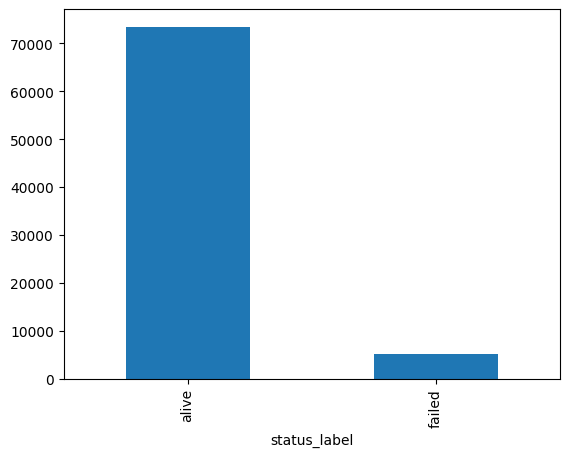

In [ ]:
# get the bar chart of status
df['status_label'].value_counts().plot(kind='bar')

---
## 3. Exploratory Data Analysis

In this section we explore the financial variables and how they differ
between healthy and distressed firms. The goal is to understand which
metrics move together and which ones separate bankrupt firms from
alive firms, before we fit any predictive models.

### 3.1 Correlation structure of financial metrics

We first examine how the 18 financial statement variables co-move
across all firms and years. To do this, we compute the Pearson
correlation matrix and visualise it as a heatmap.


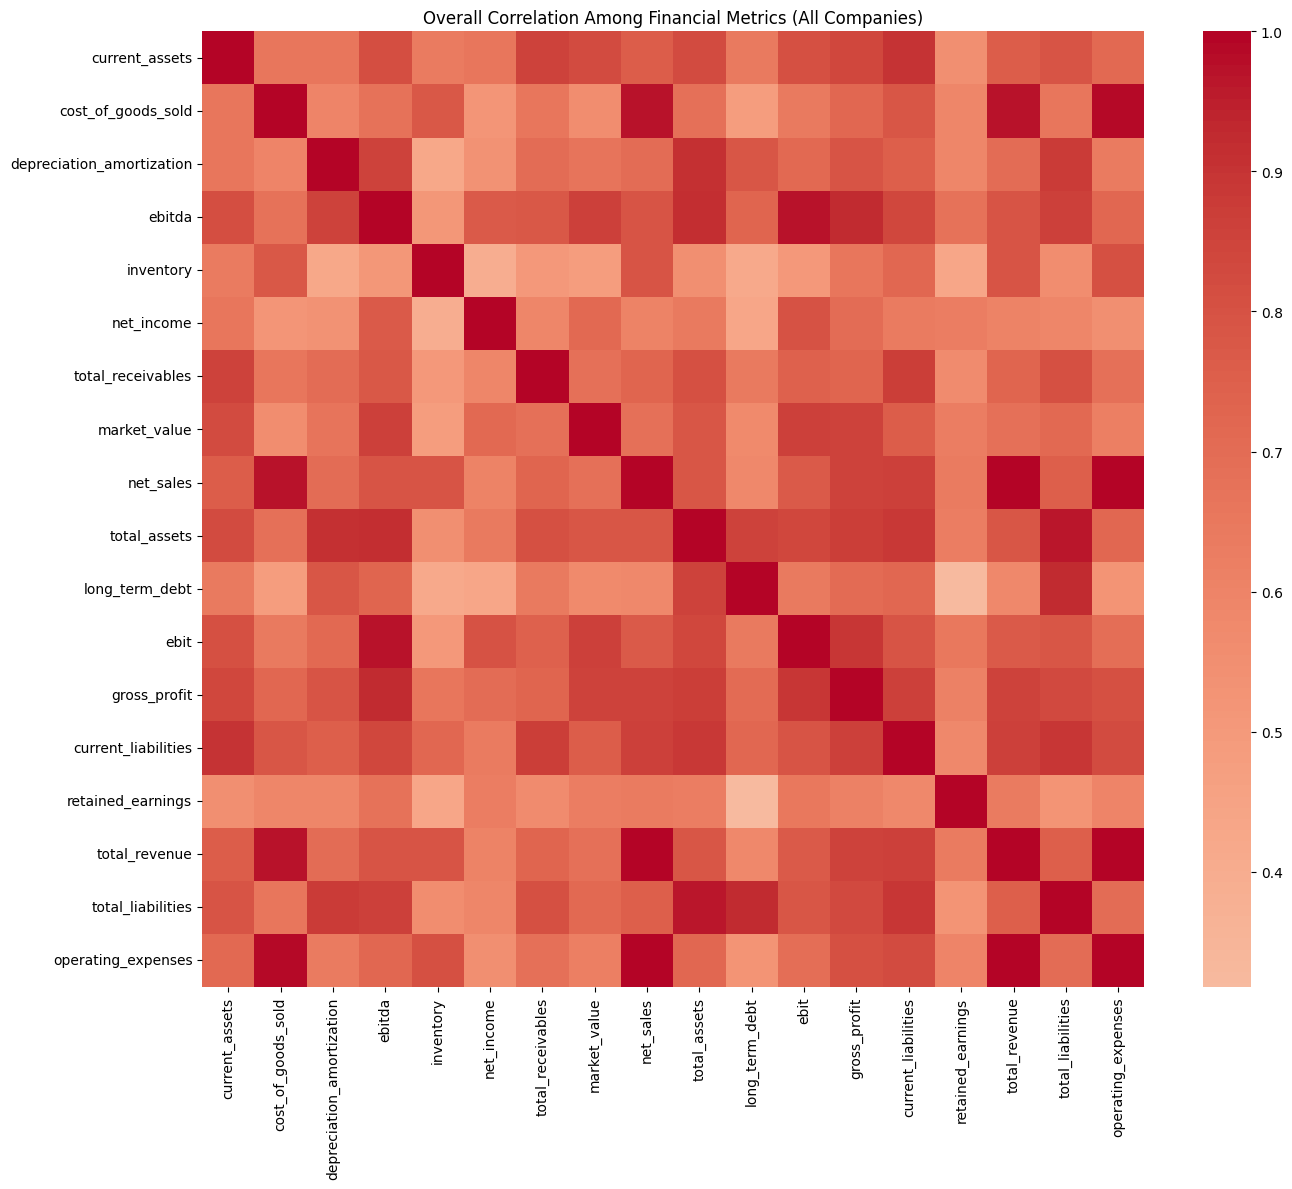

In [ ]:
# correlations between each factor
financial_cols = [
    "current_assets", "cost_of_goods_sold", "depreciation_amortization",
    "ebitda", "inventory", "net_income", "total_receivables",
    "market_value", "net_sales", "total_assets", "long_term_debt",
    "ebit", "gross_profit", "current_liabilities", "retained_earnings",
    "total_revenue", "total_liabilities", "operating_expenses"
]

corr_all = df[financial_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_all, cmap="coolwarm", center=0)
plt.title("Overall Correlation Among Financial Metrics (All Companies)")
plt.tight_layout()
plt.show()

The heatmap shows that most financial variables are **strongly
positively correlated**. For example, total assets, total revenue,
net sales, gross profit and current assets all move together, which
is intuitive because larger firms tend to have higher sales and more
assets.

Profitability-related items such as EBIT, EBITDA and net income are
also highly correlated with revenue and gross profit. This suggests
that much of the cross-sectional variation in our dataset is driven
by firm size and overall business scale.

The high degree of correlation implies that some models may suffer
from multicollinearity if we include all raw variables at once. This
motivates the use of regularised linear models and tree-based
methods in the modelling section.

### 3.2 Comparing alive and failed firms

Next, we compare financial metrics between **alive** and **failed**
firms. For each variable in our financial feature list, we compute
the mean separately for alive and failed firms and then construct
three types of differences:

- `diff`: the absolute difference in means (failed − alive);
- `std_diff`: the standardised difference, dividing `diff` by the
  overall standard deviation of the variable, so that variables are
  on a comparable scale;
- `ratio_diff`: the relative difference, defined as

\[
\text{ratio\_diff} = \frac{\text{mean(failed)} - \text{mean(alive)}}{\text{mean(alive)}}.
\]

`ratio_diff` is easy to interpret:

- `ratio_diff = -1.0` means the average failed firm is 100% lower
  than the average alive firm on that metric (for example, moving
  from a positive value to around zero or negative).
- `ratio_diff = -0.5` means failed firms are about **50% lower**
  than healthy firms.
- values close to 0 indicate only small differences, while more
  negative values correspond to more severe financial deterioration.


In [ ]:
financial_cols = [
    "current_assets","cost_of_goods_sold","depreciation_amortization",
    "ebitda","inventory","net_income","total_receivables",
    "market_value","net_sales","total_assets","long_term_debt",
    "ebit","gross_profit","current_liabilities","retained_earnings",
    "total_revenue","total_liabilities","operating_expenses"
]


mean_by_status = df.groupby("status_label")[financial_cols].mean().T


mean_by_status["diff"] = (
    mean_by_status["failed"] - mean_by_status["alive"]
)


std_overall = df[financial_cols].std()
mean_by_status["std_diff"] = mean_by_status["diff"] / std_overall

mean_by_status["ratio_diff"] = (
    mean_by_status["diff"] / mean_by_status["alive"]
)


mean_by_status.sort_values("std_diff")

status_label,alive,failed,diff,std_diff,ratio_diff
net_income,141.994726,-48.112333,-190.107058,-0.150219,-1.338832
market_value,3596.015157,857.813011,-2738.202146,-0.148701,-0.761455
ebit,269.938080,52.687657,-217.250422,-0.145353,-0.804816
current_assets,914.542615,399.339353,-515.203262,-0.131143,-0.563345
ebitda,393.684586,138.568576,-255.116009,-0.126796,-0.648021
gross_profit,800.889131,327.616175,-473.272956,-0.125380,-0.590934
total_receivables,297.794547,132.565307,-165.229240,-0.123677,-0.554843
retained_earnings,582.034710,-165.107267,-747.141977,-0.117306,-1.283673
total_revenue,2447.871581,1183.957172,-1263.914409,-0.105766,-0.516332
net_sales,2447.871581,1183.957172,-1263.914409,-0.105766,-0.516332


The table above ranks financial variables by their standardised
difference between failed and alive firms. Several clear patterns
emerge:

- **Profitability collapses before failure.**  
  Net income has a `ratio_diff` of about −1.33: on average, failed
  firms' net income is 133% lower than that of alive firms, meaning
  that they move from profit to substantial losses. Retained earnings
  show a similarly large relative gap (around −1.28), indicating large
  accumulated losses on the balance sheet. EBIT is roughly 80% lower
  in failed firms compared to healthy ones.

- **Scale and liquidity shrink substantially.**  
  Current assets in failed firms are only about 44% of those in
  healthy firms (`ratio_diff ≈ −0.56`), and total assets are about
  56% lower (`ratio_diff ≈ −0.44`). Market value is roughly 75% lower
  (`ratio_diff ≈ −0.76`), and inventory is about 50% lower. This
  suggests that firms in distress are shrinking in size and cutting
  back on operations and inventories.

- **Leverage differences are modest.**  
  Long-term debt shows a relatively small relative difference
  (`ratio_diff ≈ −0.16`). This implies that capital structure alone
  does not separate failed and healthy firms in this sample as clearly
  as profitability and asset-based measures do.

Overall, the EDA indicates that **profitability and retained earnings**
are the most discriminative indicators of distress, followed by
variables capturing firm size and liquidity. These findings directly
motivate our modelling choices later: we expect variables such as net
income, retained earnings, EBIT, current assets and market value to
play a central role in predicting bankruptcy.


------


## 4. Constructing a pre-bankruptcy prediction dataset

Our research question focuses on predicting failure *ahead of time*,
rather than simply classifying firms after they have already failed.
We therefore transform the panel data into a labelled dataset suitable
for a fixed-horizon classification task.

### 4.1 Defining the failure event and time-to-event

We first identify, for each firm that ever fails, the **event year**,
defined as the last year in which the firm is labelled as failed or
bankrupt. We then compute

years_before_event = event_year - year

for every firm–year observation. This variable tells us how many years
each observation is away from the eventual failure event.

For firms that never fail, `event_year` and `years_before_event`
remain missing; these firms will later contribute only healthy
observations to the modelling dataset.



In [ ]:
failed_mask = df["status_label"].isin(["failed", "bankrupt"])

In [ ]:
# 1. sort
df = df.sort_values(["company_name", "year"]).reset_index(drop=True)

# 2. check the real label
print(df["status_label"].value_counts())

# 3.is_failed lable
df["is_failed"] = df["status_label"].str.contains("fail", case=False)

# 4. calculate the bankruptcy year
event_year_df = (
    df[df["is_failed"]]
      .groupby("company_name")["year"]
      .max()
      .rename("event_year")
      .reset_index()
)

# 5. merge
if "event_year" in df.columns:
    df = df.drop(columns=["event_year"])

df = df.merge(event_year_df, on="company_name", how="left")

# 6. count the years before event
df["years_before_event"] = df["event_year"] - df["year"]


status_label
alive     73462
failed     5220
Name: count, dtype: int64


In [ ]:
df[["company_name","year","status_label","event_year","years_before_event"]]

,company_name,year,status_label,event_year,years_before_event
0,C_1,1999,alive,NaN,NaN
1,C_1,2000,alive,NaN,NaN
2,C_1,2001,alive,NaN,NaN
3,C_1,2002,alive,NaN,NaN
4,C_1,2003,alive,NaN,NaN
...,...,...,...,...,...
78677,C_999,2014,alive,NaN,NaN
78678,C_999,2015,alive,NaN,NaN
78679,C_999,2016,alive,NaN,NaN
78680,C_999,2017,alive,NaN,NaN


### 4.2 Three-year-ahead prediction labels

To keep the prediction task simple and focused, we construct a
one-year-ahead classification dataset:

- **Positive class (label = 1):** all firm–years where
  `years_before_event == 3` (i.e. three years before the failure
  event; we later experiment with other horizons).
- **Negative class (label = 0):** for each firm that never fails,
  we take its last available year as a healthy observation.

We then combine these into a single DataFrame `ml_df` that will be
used to train and evaluate our predictive models.

In [ ]:
pos_df = df[df["years_before_event"] == 3].copy()
pos_df["label"] = 1

alive_firms = df[~failed_mask]["company_name"].unique()
alive_df = df[df["company_name"].isin(alive_firms)].copy()
alive_last = (
    alive_df
    .sort_values(["company_name", "year"])
    .groupby("company_name")
    .tail(1)
    .copy()
)
alive_last["label"] = 0


ml_df = pd.concat([pos_df, alive_last], ignore_index=True)

print(ml_df["label"].value_counts())


label
0    8728
1     524
Name: count, dtype: int64


In [ ]:
ml_df

,company_name,status_label,year,current_assets,cost_of_goods_sold,depreciation_amortization,ebitda,inventory,net_income,total_receivables,...,gross_profit,current_liabilities,retained_earnings,total_revenue,total_liabilities,operating_expenses,is_failed,event_year,years_before_event,label
0,C_1020,failed,2001,162.621,339.368,19.772,21.378,7.600,7.810,41.202,...,77.545,44.781,122.661,416.913,52.482,395.535,True,2004.0,3.0,1
1,C_1058,failed,2011,639.044,154.160,15.192,180.384,111.943,117.526,70.679,...,242.671,178.623,6.597,396.831,409.895,216.447,True,2014.0,3.0,1
2,C_1085,failed,2001,3790.000,9945.000,529.000,-40.000,273.000,-423.000,512.000,...,-40.000,4146.000,-823.000,9905.000,13159.000,9945.000,True,2004.0,3.0,1
3,C_1114,failed,2004,18.650,11.719,0.321,-11.687,0.000,-10.576,0.000,...,-11.687,2.175,-53.067,0.032,2.175,11.719,True,2007.0,3.0,1
4,C_1144,failed,2005,8867.000,5932.000,302.000,322.000,1804.000,-2575.000,2930.000,...,4591.000,8068.000,-36427.000,10523.000,16546.000,10201.000,True,2008.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,C_995,alive,2005,1496.536,4245.911,167.547,201.550,633.657,-81.947,672.734,...,655.204,1346.399,654.274,4901.115,3140.893,4699.565,False,NaN,NaN,0
9248,C_996,alive,2001,62.788,74.934,3.346,-0.613,36.729,-4.989,25.152,...,16.616,75.197,20.945,91.550,77.640,92.163,False,NaN,NaN,0
9249,C_997,alive,2018,1479.900,2897.900,139.400,1081.500,786.300,933.400,518.100,...,2511.000,2001.700,1400.300,5408.900,7074.200,4327.400,False,NaN,NaN,0
9250,C_998,failed,2018,3033.000,6072.000,177.000,331.000,805.000,-2687.000,1107.000,...,633.000,4217.000,-2826.000,6705.000,8387.000,6374.000,True,2018.0,0.0,0


In [ ]:
# train_test_split
ml_df = ml_df.copy()

y = ml_df["label"]

X = ml_df[financial_cols].fillna(ml_df[financial_cols].median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## 5. Different Models Camparison

### 5.1 Logistic Regression: Performance

Using a balanced logistic regression with standardised features, the
test-set accuracy is **0.34**. This is much lower than a naive baseline
that always predicts “healthy”, which would achieve about **94%**
accuracy (2619/2776), but the logistic model behaves very differently
across the two classes.

- For healthy firms (label 0), precision is **0.96** and recall is
  **0.32**. The model is very conservative in calling a firm healthy
  and correctly identifies only about one third of the healthy
  observations.
- For failed firms (label 1), precision is only **0.06**, but recall
  is **0.78**. The model captures around 78% of the future failures,
  at the cost of many false alarms.

This behaviour is driven by two design choices: we use
`class_weight="balanced"` to up-weight the minority “failed” class in
the loss function, and we keep the default probability threshold of 0.5.
In the context of early-warning systems, this trade-off can be
reasonable—missing a truly failing firm is typically more costly than
raising a false alarm—but the very low precision for the failed class
(0.06) suggests that additional filtering or alternative models are
needed to make the signals practically usable.


In [ ]:
from sklearn.pipeline import Pipeline
logit_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

logit_clf.fit(X_train, y_train)

y_pred_logit = logit_clf.predict(X_test)
y_proba_logit = logit_clf.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logit))
print(classification_report(y_test, y_pred_logit))

=== Logistic Regression ===
Accuracy: 0.34365994236311237
              precision    recall  f1-score   support

           0       0.96      0.32      0.48      2619
           1       0.06      0.78      0.12       157

    accuracy                           0.34      2776
   macro avg       0.51      0.55      0.30      2776
weighted avg       0.91      0.34      0.46      2776



### 5.2 Interpreting Logistic Regression Coefficients

Because we standardise all financial variables before fitting the model,
the logistic regression coefficients are directly comparable: each
coefficient measures the change in the log-odds of failure associated
with a one-standard-deviation change in that variable, holding the
others fixed.

On the **protective** side, the largest negative coefficient is for
`market_value` (≈ −4.89), followed by `current_liabilities` (≈ −1.78),
`total_receivables` (≈ −0.86), `net_income` (≈ −0.74),
`long_term_debt` (≈ −0.71) and `inventory` (≈ −0.39). Higher values of
these variables are associated with *lower* predicted distress risk.
This is broadly consistent with our EDA: firms that remain healthy tend
to be larger, more profitable and have higher market valuations.

On the **risk-increasing** side, the strongest positive effects come
from `total_liabilities` (≈ +2.36), `gross_profit` (≈ +0.99) and
`total_assets` (≈ +0.75), followed by `operating_expenses` and the
sales variables (`total_revenue`, `net_sales`). Conditional on the
other size and profitability measures, firms with unusually high total
liabilities appear more likely to fail, which fits the idea that
excessive leverage becomes dangerous once we control for scale. The
positive coefficients on some size-related variables (e.g. total assets
and gross profit) likely reflect multicollinearity: many size and
performance metrics move together, so the model attributes risk to the
overall combination of “being large but highly leveraged” rather than
to a single variable in isolation.

Overall, the logistic regression confirms the main patterns from our
descriptive analysis: distress is most closely linked to weak
profitability and low market value, while leverage—especially total
liabilities—becomes problematic when it is high relative to the firm’s
scale. Because the predictors are highly correlated, individual
coefficient signs should be interpreted with caution, but the variables
with the largest magnitudes (market value and total liabilities) provide
a clear qualitative picture of risk.

In [ ]:
logit_model = logit_clf.named_steps["clf"]
coef_table = pd.DataFrame({
    "feature": financial_cols,
    "coef": logit_model.coef_[0]
}).sort_values("coef")

coef_table

,feature,coef
7,market_value,-4.888971
13,current_liabilities,-1.781756
6,total_receivables,-0.858233
5,net_income,-0.737747
10,long_term_debt,-0.709585
4,inventory,-0.392756
3,ebitda,-0.281752
14,retained_earnings,-0.278553
2,depreciation_amortization,-0.274982
11,ebit,-0.258913


/tmp/ipython-input-1502695559.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_table_sorted, x="coef", y="feature", palette="coolwarm")


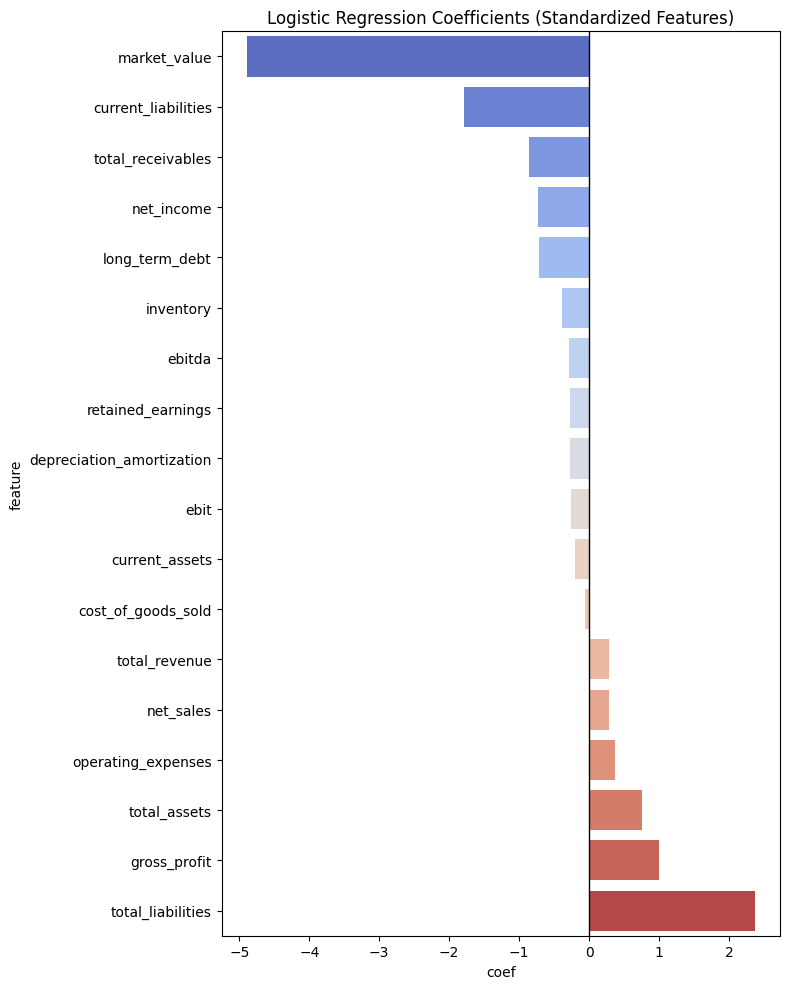

In [ ]:
coef_table_sorted = coef_table.sort_values("coef")

plt.figure(figsize=(8, 10))
sns.barplot(data=coef_table_sorted, x="coef", y="feature", palette="coolwarm")
plt.title("Logistic Regression Coefficients (Standardized Features)")
plt.axvline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()

### 5.3 XGBoost


In [ ]:
# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() # to balance the class
)

xgb_clf.fit(X_train, y_train)

y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

print("=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

=== XGBoost ===
Accuracy: 0.8220461095100865
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      2619
           1       0.11      0.30      0.16       157

    accuracy                           0.82      2776
   macro avg       0.53      0.58      0.53      2776
weighted avg       0.91      0.82      0.86      2776



The XGBoost model achieves a test-set accuracy of **0.82**, which is
much higher than the logistic regression baseline (0.34). However, the
class-wise performance shows again a strong asymmetry between healthy
and distressed firms:

- For healthy firms (label 0), precision is **0.95** and recall is
  **0.85** (F1 = 0.90, support = 2619). The model is very good at
  recognising firms that will remain alive.
- For failed firms (label 1), precision is **0.11** and recall is
  **0.30** (F1 = 0.16, support = 157). Only about 30% of future
  failures are detected, but when the model predicts failure it is
  correct roughly 11% of the time.

Compared with the balanced logistic regression, XGBoost **moves in the
opposite direction** along the early-warning trade-off:

- Logistic regression sacrifices overall accuracy to obtain high recall
  on the failed class (≈ 0.78) but extremely low precision (≈ 0.06).
- XGBoost recovers high overall accuracy and a much better balance for
  healthy firms, but recall on failures drops to 0.30.

For our application – monitoring firms on the path to bankruptcy –
XGBoost is therefore a more conservative early-warning model: it issues
fewer false alarms than the logistic model, but it also misses a larger
fraction of distressed firms. This highlights the inherent trade-off
faced by banks and regulators when designing screening rules for
financial distress.

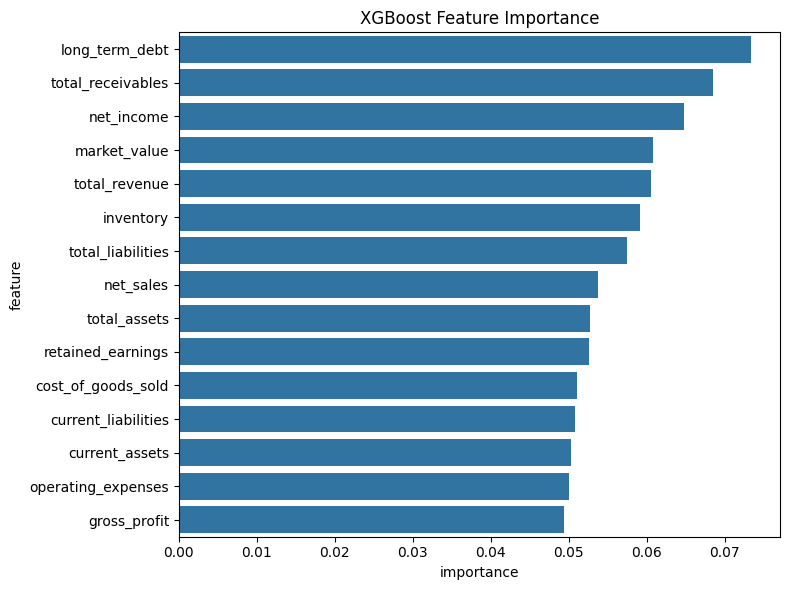

In [ ]:
xgb_importance = pd.DataFrame({
    "feature": financial_cols,
    "importance": xgb_clf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=xgb_importance.head(15), x="importance", y="feature")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

### 5.4 XGBoost Feature Importance and Distress Progression

The XGBoost feature importance plot shows that the top predictors of
three-years-ahead failure are:

1. **long_term_debt**
2. **total_receivables**
3. **net_income**
4. **market_value**
5. **total_revenue**
6. **inventory**
7. **total_liabilities**
8. **net_sales**
9. **total_assets**
10. **retained_earnings**

This ranking is highly consistent with our EDA and our research
questions about the *financial distress trajectory*:

- **Profitability and accumulated losses.**  
  `net_income` and `retained_earnings` appear among the most important
  variables. This mirrors our earlier finding that failed firms have
  net income about 130% lower and retained earnings about 128% lower
  than healthy firms. Deterioration in profitability is therefore a
  central early-warning signal.

- **Scale and market valuation.**  
  `market_value`, `total_revenue`, `net_sales`, `total_assets`,
  `inventory` and `total_receivables` all rank near the top. Together
  they capture the gradual shrinking of the firm: declining sales,
  smaller asset base, and a collapsing equity valuation as the firm
  approaches bankruptcy.

- **Leverage and debt structure.**  
  Both `long_term_debt` and `total_liabilities` are important in the
  XGBoost model, even though long-term debt showed only modest average
  differences in the simple mean comparison. This suggests that
  non-linear interactions between debt levels and other variables
  (e.g. profitability and asset size) matter for predicting distress,
  which tree-based models can capture more effectively than a purely
  linear specification.

Overall, XGBoost confirms the picture of a “three-year path to death”:
firms that eventually fail tend to combine **weak earnings, shrinking
scale and problematic debt levels**, and these patterns are detectable
by a flexible non-linear model several years before the event.

### 5.3 Neuaral Network

In [ ]:
# use Deep learning network
!pip install torch

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# 1) Standardize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 2) torch tensor
X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)

In [ ]:
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

In [ ]:
input_dim = X_train_t.shape[1]

class BankruptcyNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BankruptcyNet(input_dim).to(device)

# balance the weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = torch.tensor(neg / pos, dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 30

for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} - train loss: {epoch_loss:.4f}")

Epoch 05 - train loss: 1.2571
Epoch 10 - train loss: 1.2239
Epoch 15 - train loss: 1.2020
Epoch 20 - train loss: 1.2078
Epoch 25 - train loss: 1.1808
Epoch 30 - train loss: 1.1762


### 5.5 Deep Neural Network: Training Behaviour

We also experiment with a fully connected neural network
(`BankruptcyNet`) with three hidden layers (64–32–32 units) and ReLU
activations, trained with `BCEWithLogitsLoss` and a class-weighted loss
that up-weights failed firms. Inputs are standardised using the same
`StandardScaler` as in the linear models.

During 30 epochs of training the loss decreases only mildly, from about
**1.26** at epoch 5 to **1.18** at epoch 30. The network does not show
signs of severe overfitting, but it also does not drive the loss much
lower, indicating that it struggles to fit the minority (failed) class
given our sample size and feature set.

This behaviour is consistent with recent evidence that, on structured
tabular data with limited observations and strong class imbalance,
boosting methods such as XGBoost typically outperform multilayer
perceptrons.


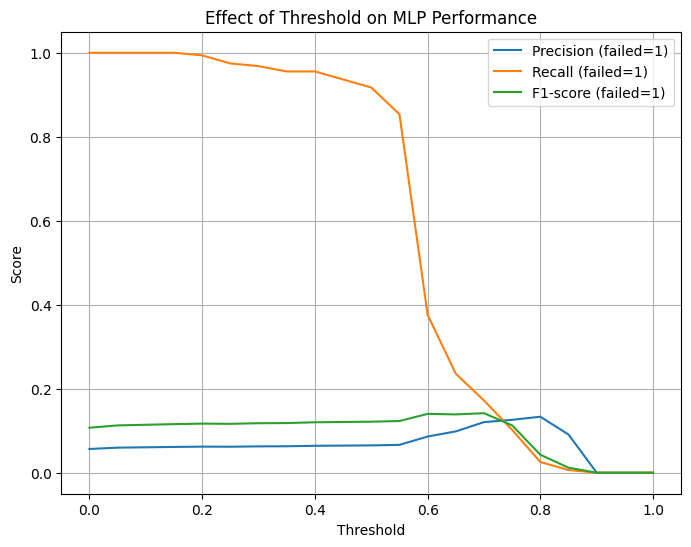

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t.to(device))
    proba_test = torch.sigmoid(logits_test).cpu().numpy().ravel()

thresholds = np.arange(0.0, 1.01, 0.05)

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred = (proba_test > t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))
    f1s.append(f1_score(y_test, y_pred, zero_division=0))
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label="Precision (failed=1)")
plt.plot(thresholds, recalls, label="Recall (failed=1)")
plt.plot(thresholds, f1s, label="F1-score (failed=1)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Effect of Threshold on MLP Performance")
plt.legend()
plt.grid(True)
plt.show()

### 5.6 Threshold Effects and Comparison with Tree-based Models

For the neural network we compute precision, recall and F1 for the
failed class across a grid of decision thresholds from 0.00 to 1.00.
The threshold curves show that the model assigns **very low predicted
probabilities** to most firms, including many that actually fail. As a
result:

- Recall for the failed class is only non-zero at very low thresholds,
  and even then it remains modest.
- Precision stays low across all thresholds, and the F1-score curve
  never reaches the level achieved by the XGBoost model.

In other words, the MLP hardly separates bankrupt firms from healthy
ones in probability space; its output probabilities are mostly crowded
near zero. This aligns with the training-loss behaviour and highlights
several challenges:

1. **Tabular data.** For medium-sized tabular datasets, boosted trees
   are known to dominate MLPs because they naturally handle non-linear
   interactions and variable scaling.
2. **Severe class imbalance.** Even with a class-weighted loss, the
   minority “failed” class is difficult for the network to learn, and
   the model tends to default to predicting the majority class.
3. **Limited signal-to-noise.** Our early-warning horizon is three
   years ahead; at this distance, the financial signals are relatively
   weak, and tree-based models appear better at extracting them.

Therefore, while the neural network is an interesting non-linear
benchmark, in this setting it does **not** outperform the simpler
XGBoost model and offers limited additional predictive power.

### 5.7 Overall Comparison

Putting all three models together:

- **Logistic regression** focuses on recall for failing firms
  (≈ 0.78) at the expense of overall accuracy and precision. It is
  useful as a very aggressive “screening” rule that flags almost all
  distressed firms but also generates many false alarms.

- **XGBoost** achieves the best overall performance with accuracy
  ≈ 0.82, precision ≈ 0.11 and recall ≈ 0.30 for the failed class.
  It detects a smaller fraction of bankruptcies but does so with
  considerably fewer false positives. Together with its feature
  importance ranking, this makes XGBoost our preferred early-warning
  model for practical use.

- The **deep neural network** underperforms both tree-based and linear
  models on this tabular, highly imbalanced dataset. Its probability
  outputs concentrate near zero and its F1-score for failures never
  matches the XGBoost benchmark.



## 6. Business Value: Early-Warning Trade-offs
From the perspective of our research questions:
- RQ1 & RQ2: All models agree that profitability, market value and
  balance-sheet size contain the strongest early-warning signals; these
  variables deteriorate well before the bankruptcy event.
- RQ3: Yes, it is possible to build a predictive model that flags risky
  firms 3 years before failure, but there is a clear trade-off between
  recall and precision. XGBoost offers the most balanced compromise.
- RQ4: The differences in performance and variable importance across
  models support the idea of a **progressive distress path**: shrinking
  scale, falling earnings and rising effective leverage jointly drive
  firms towards bankruptcy.

This multi-model evidence gives a coherent picture of how firms move
along the financial distress progression in the three years leading up
to bankruptcy.